This notebook is for training and saving models following the two step procedure.

In [40]:

import os
import sys
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

print(sys.executable)
import platform 
print(platform.python_version())

import glob

#from tqdm import tqdm
import numpy as np
import scipy.ndimage
import scipy.misc
import pandas as pd
import pickle
from IPython.display import clear_output

import keras
from keras.layers.core import Dense, Flatten, Dropout
from keras.layers import Concatenate
from keras.layers import Input
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
# import the necessary packages
from keras.preprocessing import image as image_utils
from keras.utils import plot_model
from keras import backend as K
from keras.regularizers import Regularizer


# from sklearn.model_selection import StratifiedKFold
# from sklearn import preprocessing
# from sklearn import svm
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.linear_model import LogisticRegression
#from sklearn import cross_validation, grid_search
import keras_metrics
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

from scipy import stats

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess) # reference: https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

import sys
sys.path.append('/nfs/juhu//data/rakhasan/reputation/jupyter-notes/bystander-project/') #for helper
#import helper

/nfs/juhu/data/rakhasan/keras-env/bin/python
3.6.9


In [41]:
IMG_SIZE = (256, 256)
IN_SHAPE = (*IMG_SIZE, 3)
BATCH_SIZE = 64

In [42]:
openImg_path = '/nfs/juhu/data/rakhasan/bystander-detection/google-img-db/'
survey_path='/nfs/juhu/data/rakhasan/bystander-detection/pilot3_coco/'
#survey_path='/nfs/juhu/data/rakhasan/bystander-detection/pilot-study2/'
survey_photo_path = survey_path+'/photos/'

#model_output_path = '/nfs/juhu/data/rakhasan/bystander-detection/trained-models/'

print('loading features.')
'''Note: this data frame has all deep features, and the label is binary values (0,1)'''
feature_df = pd.read_pickle(os.path.join(survey_path, 'all-features-df.pkl'))
#feature_df = feature_df[(feature_df.label==1)|(feature_df.label==-1)]
#feature_df['label'] = feature_df.apply(lambda row: 1 if row.label==1 else 0, axis=1)
print('dataset:',len(feature_df), 'unique labels:', feature_df.label.unique(),
     'pos:',len(feature_df[feature_df.label==1]),'neg:',len(feature_df[feature_df.label==0]))

loading features.
dataset: 736 unique labels: [0 1] pos: 409 neg: 327


In [34]:
'''Feature names'''

#joint names labeled by openpose
body_joint_names = ['nose', 'neck', 'Rsho', 'Relb', 'Rwri', 'Lsho', 'Lelb',
               'Lwri', 'Rhip', 'Rkne', 'Rank', 'Lhip', 'Lkne', 'Lank', 
               'Leye', 'Reye', 'Lear', 'Rear']

#angles between pairs of body joint, from openpose
link_angle_features = ['angle_'+str(i) for i in range(17)]

#probability of detecting a body joint, from openpose
body_joint_prob_features = [j + '_prob' for j in body_joint_names]

face_exp_feaures = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']

img_level_features = ['person_distance', 'person_size', 'num_people']

visual_features = img_level_features +\
    link_angle_features + body_joint_prob_features + face_exp_feaures

features_from_study = ['was_aware_num',  'posing_num',  'comfort_num',  'will_num', 'photographer_intention_num',
     'replacable_num',  'photo_place_num']

resnet_feature_cols = ['resnet_feat_{}'.format(i) for i in range(131071)]

resnet_feat_avg_cols = ['resnet_feat_avg_{}'.format(i) for i in range(2048)]

all_features = features_from_study + visual_features + resnet_feat_avg_cols

In [35]:
from keras import optimizers

def linear_regression_model(input_dim=38, hidden_dims = []):
    '''Create a fully connected network with first layer as input with input_dim=input_dim,
    and len(hidden_dims) number of hidden layers.
    
    Currenly default activation is relu for all hidden layers, and a dropout(.5) is added.
    
    '''
    
    input_layer = Input(shape=(input_dim,), name = 'input_layer')
    hidden_layer = input_layer
    if hidden_dims:
        for hidden_dim in hidden_dims:
            hidden_layer = Dense(hidden_dim, activation='relu')(hidden_layer)
            hidden_layer = Dropout(.5)(BatchNormalization()(hidden_layer))
    
    output_layer = Dense(1, kernel_regularizer=keras.regularizers.l2(1), bias_regularizer=keras.regularizers.l2(1), 
                         activation = 'linear')(hidden_layer)
    
    model = Model(input_layer, output_layer)
    
    model.compile(optimizer=optimizers.SGD( lr = 0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=0.5),
                  loss='mse',
                  metrics=['mse','mae'])
    return model

### Predict and save high-level features

In [36]:

#feat = resnet_feat_avg_cols + img_level_features + link_angle_features + body_joint_prob_features + face_exp_feaures
feat = resnet_feat_avg_cols  + link_angle_features + body_joint_prob_features + face_exp_feaures

will_model = linear_regression_model(input_dim=len(feat), hidden_dims=[64])
will_model.fit(feature_df[feat].apply(stats.zscore).values, feature_df['will_num'],
          epochs=30, batch_size=BATCH_SIZE, verbose=0)
feature_df['predicted_will'] = will_model.predict(feature_df[feat].apply(stats.zscore).values)

comfort_model = linear_regression_model(input_dim=len(feat), hidden_dims=[64])
comfort_model.fit(feature_df[feat].apply(stats.zscore).values, feature_df.comfort_num,
          epochs=30, batch_size=BATCH_SIZE, verbose=0)
feature_df['predicted_comfort'] =comfort_model.predict(feature_df[feat].apply(stats.zscore).values)


aware_model = linear_regression_model(input_dim=len(feat), hidden_dims=[64])
aware_model.fit(feature_df[feat].apply(stats.zscore).values, feature_df.was_aware_num,
          epochs=30, batch_size=BATCH_SIZE, verbose=0)
feature_df['predicted_aware'] = aware_model.predict(feature_df[feat].apply(stats.zscore).values)

pose_model = linear_regression_model(input_dim=len(feat), hidden_dims=[64])
pose_model.fit(feature_df[feat].apply(stats.zscore).values, feature_df.posing_num,
          epochs=30, batch_size=BATCH_SIZE, verbose=0)
feature_df['predicted_posing'] = pose_model.predict(feature_df[feat].apply(stats.zscore).values)

replace_model = linear_regression_model(input_dim=len(feat), hidden_dims=[64])
replace_model.fit(feature_df[feat].apply(stats.zscore).values, feature_df.replacable_num,
          epochs=30, batch_size=BATCH_SIZE, verbose=0)
feature_df['predicted_replace'] =replace_model.predict(feature_df[feat].apply(stats.zscore).values)


intention_model = linear_regression_model(input_dim=len(feat), hidden_dims=[64])
intention_model.fit(feature_df[feat].apply(stats.zscore).values, feature_df.photographer_intention_num,
          epochs=30, batch_size=BATCH_SIZE, verbose=0)
feature_df['predicted_intention'] =intention_model.predict(feature_df[feat].apply(stats.zscore).values)

In [37]:
feature_df.isnull().any()

was_aware_num                 False
posing_num                    False
comfort_num                   False
will_num                      False
photographer_intention_num    False
                              ...  
predicted_comfort             False
predicted_aware               False
predicted_posing              False
predicted_replace             False
predicted_intention           False
Length: 2107, dtype: bool

In [38]:
feature_df[['predicted_will',
 'predicted_comfort',
 'predicted_aware',
 'predicted_posing',
 'predicted_replace',
 'predicted_intention', 
 'label']].head()

,predicted_will,predicted_comfort,predicted_aware,predicted_posing,predicted_replace,predicted_intention,label
photo_no,,,,,,,
0,-0.207411,0.225783,-1.435511,-0.899200,2.325538,0.110946,0
1,1.169484,1.634214,1.928841,1.147455,-0.357026,2.269445,1
2,1.004296,1.452311,1.699763,1.106198,-0.008909,1.652262,1
4,0.033320,-0.348885,-0.961519,-0.625098,2.071091,-1.514274,0
6,0.552046,0.305383,0.234616,-0.787203,0.818279,0.483145,0


In [39]:
'''Save new feature dataframe with predicted values of the concepts'''
feature_df[['predicted_will',
 'predicted_comfort',
 'predicted_aware',
 'predicted_posing',
 'predicted_replace',
 'predicted_intention', 
 'person_size',
 'label']+ features_from_study].to_pickle(os.path.join(survey_path, 'predicted-concepts-df.pkl'))

In [181]:
#https://github.com/m-peker/ResNet-Layers-Visualization/blob/master/ResNet-Layers-Visualization.ipynb
def plot_activations(layer_activation):#layer_idx, activations):
    #layer_activation = activations[layer_idx][0]
    n_row = 4
    n_column = layer_activation.shape[-1]//n_row
    print(n_column)
    f, ax = plt.subplots(n_row, n_column, figsize=(8,8))
    for i in range(n_row):
        for j in range(n_column):
            channel_image = layer_activation[:, :, i*n_column+j]
            #print(channel_image.shape)
            # image post-processing for better visualization
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        
            ax[i, j].imshow(channel_image, cmap='viridis')
            ax[i, j].axis('off')
            ax[i, j].set_xticklabels([])
            ax[i, j].set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    f.set_size_inches(n_column*2, n_row*2)
    plt.show()
    
def plot_activations(layer_idx, activations):
    layer_activation = activations[layer_idx][0]
    n_row = 8
    n_column = layer_activation.shape[-1]//n_row
    
    f, ax = plt.subplots(n_row, n_column)
    for i in range(n_row):
        for j in range(n_column):
            channel_image = layer_activation[:, :, i*n_column+j]
            # image post-processing for better visualization
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        
            ax[i, j].imshow(channel_image, cmap='viridis')
            ax[i, j].axis('off')
            ax[i, j].set_xticklabels([])
            ax[i, j].set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    f.set_size_inches(n_column, n_row)
    plt.show()

In [152]:
x=feature_df.loc[526][resnet_feat_avg_cols].values.reshape((16,16,8))
x.shape

(16, 16, 8)

2


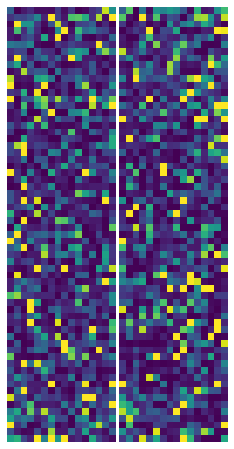

In [153]:
plot_activations(x)

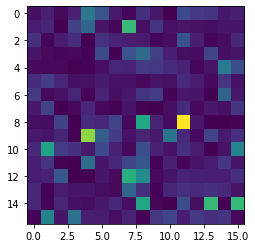

In [103]:
plt.imshow(x[1].reshape((16,16)))
plt.show()

In [124]:
2048/64

32.0

In [230]:
m.summary()

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [254]:
model=m
layer_outputs = [layer.output for layer in model.layers if not layer.name.startswith('input')]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
#activation_model

In [255]:
activation_model.summary()
#model.layers[0].output

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [274]:
img='//nfs/juhu/data/rakhasan/bystander-detection/pilot-study2/cropped-photos/2153.jpg'
img = get_cropped(img)

pred=activation_model.predict(img.reshape(1,256,256,3))

In [275]:
pred[-3].shape
img.shape

(256, 256, 3)

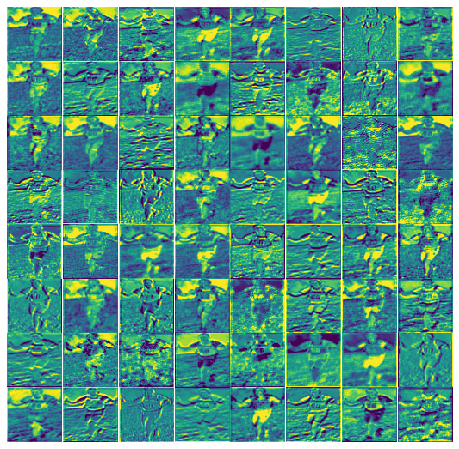

In [276]:
plot_activations(10, pred)

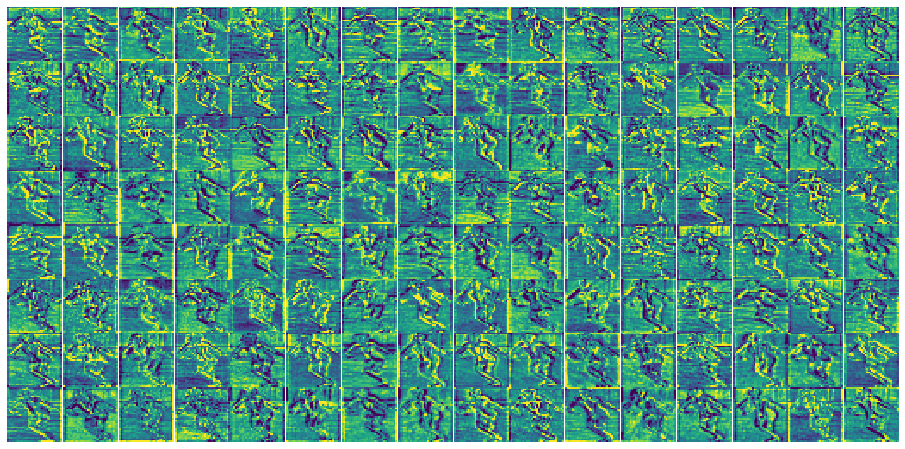

In [266]:
plot_activations(50, pred)

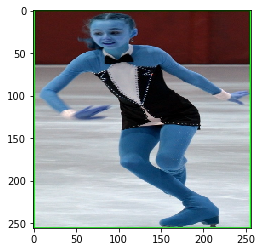

(256, 256, 3)

In [260]:
img='//nfs/juhu/data/rakhasan/bystander-detection/pilot-study2/cropped-photos/1019.jpg'
img = get_cropped(img)
#img=cv2.imread(img)
plt.imshow(img)
plt.show()
img.shape

In [259]:
def get_cropped(path):
    try:
        img = cv2.imread(path)
        resized=cv2.resize(img, 
                       dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
        return resized
    except Exception as e:
        print( e)

In [208]:
pred[0].shape

(1, 230, 230, 3)

In [182]:
plot_activations(1,p[0])

IndexError: index 1 is out of bounds for axis 0 with size 1

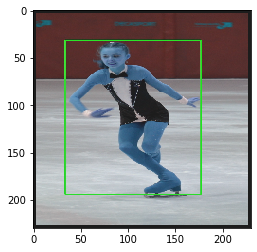

In [225]:
channel_image=pred[0][0]
# channel_image -= channel_image.mean()
# channel_image /= channel_image.std()
# channel_image *= 64
# channel_image += 128
channel_image=np.clip(channel_image, 0, 255).astype('uint8')
plt.imshow(channel_image)
plt.show()

In [213]:
pred[0][0].shape

(230, 230, 3)

In [200]:
layer_outputs[-3]

<tf.Tensor 'activation_147/Relu:0' shape=(?, 7, 7, 2048) dtype=float32>

In [229]:
m.layers[-2].name

'activation_49'

In [267]:
feature_df[face_exp_feaures]

,angry,disgusted,fearful,happy,sad,surprised,neutral
photo_no,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.192004,0.154751,0.103244,0.210520,0.128919,0.136950,0.073611
2,0.218816,0.145022,0.097719,0.223863,0.107621,0.143445,0.063514
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
882,0.195124,0.130079,0.091004,0.248404,0.134995,0.142879,0.057514
887,0.200894,0.152956,0.132302,0.148268,0.118127,0.178335,0.069118
888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
